# `gitermap` examples (2)

In this notebook we will cover some more detailed examples using `scikit-learn` to iteratively fit models. Here we will use the Boston dataset and hyperparameter tune using `gitermap` to find the best $\alpha$ regularization parameter.

**Note**: For this example you will need `matplotlib`, `numpy` and `scikit-learn` installed.

In [183]:
from gitermap import MapContext

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools as it

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import scale
from sklearn.linear_model import Ridge
from sklearn.datasets import load_boston

## Example 1: Boston housing

Load the data.

In [184]:
boston = load_boston()

In [185]:
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

Constructing a function that computes the test scores across multiple cross validations, for a given alpha.

In [186]:
def compute_test_score(alpha, cv, X, y):
    # preprocess X, y
    X_new = scale(X)
    return cross_val_score(Ridge(alpha), X_new, y, cv=cv, scoring="r2")

Test the example (to see it works!)

In [187]:
compute_test_score(1., 5, boston.data, boston.target)

array([ 0.64333037,  0.71683688,  0.58814318,  0.08214252, -0.22702517])

### Computing over $\alpha$ with `gitermap`.

Note that we compute once and save the result, so re-running merely loads the data in from file.

In [188]:
a_samples = np.linspace(-4., 5.5, 50)
with MapContext(verbose=1) as ctx1:
    alpha1 = ctx1.compute(compute_test_score, a_samples, cv=5, X=boston.data, y=boston.target)

100%|██████████| 50/50 [00:01<00:00, 36.13it/s]


Now for plotting the results.

Note that we concatenate the results, calculate the mean and then clip between 0 and 1 to avoid certain spurious samples which give negative $r^2$.

In [189]:
clean_alpha1 = np.vstack((alpha1))

Text(0.5, 1.0, 'Boston dataset over $\\alpha$ with $r^2 \\pm$SD')

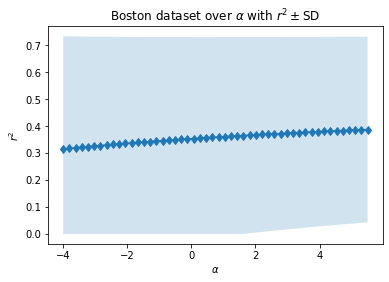

In [190]:
plt.plot(a_samples, clean_alpha1.mean(1), 'd-')
plt.fill_between(a_samples, np.clip(clean_alpha1.mean(1) + clean_alpha1.std(1), 0, 1),
                 np.clip(clean_alpha1.mean(1) - clean_alpha1.std(1), 0, 1), alpha=.2)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$r^2$")
plt.title(r"Boston dataset over $\alpha$ with $r^2 \pm$SD")

But why limit ourselves to $\alpha$? We could choose to parameterize over the cross-validation split also. To do this, we can use the `itertools.product` method to combine together `a_samples` and some cross-validation metrics.

Rather annoyingly, we must write a new function, combine together alpha and cv into a `params` argument, and then unpack them inside the custom function.

In [191]:
def compute_test_score2(params, X, y):
    # preprocess X, y
    alpha, cv = params
    X_new = scale(X)
    return cross_val_score(Ridge(alpha), X_new, y, cv=cv, scoring="r2")

In [192]:
import itertools as it

In [193]:
with MapContext() as ctx2:
    alpha2 = ctx2.compute(compute_test_score2, it.product(a_samples, [3, 5, 10]), X=boston.data, y=boston.target)

150it [00:04, 34.77it/s]


You may spot that for the first 50 iterations, a progressbar is drawn, but then changes until 150it. This is because an estimate of the number of runs is made based on the length of each argument, assuming that all arguments are the same length.

#### Computing the product of variables.

To adjust for this, we provide a `compute_prod` function, which computes the product of multiple arguments, and performs the necessary calculations for you, so you can just pass your arguments in. Arguments that you want to simply zip over as before, you can do exactly that! Call `zip()` or `it.zip_longest()`. As before, keyword arguments are called on every iteration.

This means we can now re-use our old function (assuming the product-arguments are the first in the function) like so:

In [194]:
with MapContext() as ctx2_5:
    alpha2_5 = ctx2_5.compute_prod(compute_test_score, a_samples, [3, 5, 10], X=boston.data, y=boston.target)

100%|██████████| 150/150 [00:04<00:00, 34.27it/s]


And now to plot our work...

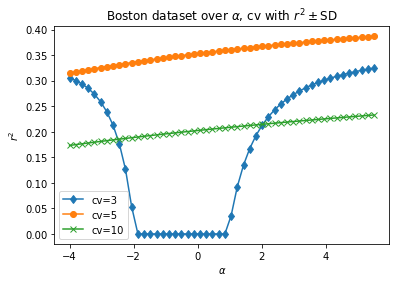

In [195]:
plt.plot(a_samples, np.clip(np.vstack(alpha2_5[::3]).mean(1), 0, 1), 'd-', label="cv=3")
plt.plot(a_samples, np.vstack(alpha2_5[1::3]).mean(1), 'o-', label="cv=5")
plt.plot(a_samples, np.vstack(alpha2_5[2::3]).mean(1), 'x-', label="cv=10")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$r^2$")
plt.title(r"Boston dataset over $\alpha$, cv with $r^2 \pm$SD")
plt.legend()
plt.show()

Here we see a massive variance over cross-validations: it would be better to get $K$ repeats for each cv to more properly model the variance here.

Here we will use scikit-learns `RepeatedKFold` function which not only lets us select cross-validates, but also a number of replicates. Note that this could significantly affect model performance.

In [196]:
from sklearn.model_selection import RepeatedKFold

In [197]:
with MapContext(n_jobs=-1) as ctx3:
    alpha3 = ctx3.compute_prod(compute_test_score, a_samples, [5, RepeatedKFold(n_splits=5, n_repeats=5)],
                          X=boston.data, y=boston.target)

  0%|          | 0/100 [00:00<?, ?it/s]

Now for arranging and plotting the results....

Isn't that a big difference?!

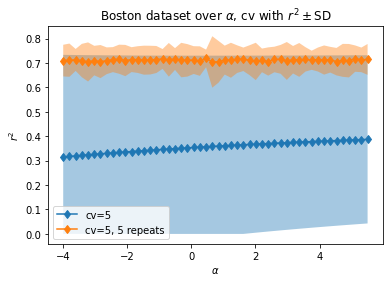

In [198]:
a31_mean = np.vstack(alpha3[::2]).mean(1)
a31_sd = np.vstack(alpha3[::2]).std(1)
a32_mean = np.vstack(alpha3[1::2]).mean(1)
a32_sd = np.vstack(alpha3[1::2]).std(1)

plt.plot(a_samples, a31_mean, 'd-', label="cv=5")
plt.fill_between(a_samples, np.clip(a31_mean + a31_sd, 0, 1),
                 np.clip(a31_mean - a31_sd, 0, 1), alpha=.4)
plt.plot(a_samples, a32_mean, 'd-', label="cv=5, 5 repeats")
plt.fill_between(a_samples, np.clip(a32_mean + a32_sd, 0, 1),
                 np.clip(a32_mean - a32_sd, 0, 1), alpha=.4)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$r^2$")
plt.title(r"Boston dataset over $\alpha$, cv with $r^2 \pm$SD")
plt.legend()
plt.show()

## Example 2: Breast Cancer

It is clear that there was a problem with splitting the domain, giving some scores very low (in the negatives). A repeated K-fold cross-validation approach helped to resolve this, give a better accuracy and significantly smaller variance. All helped by our methodology.

Now we move onto another example using breast cancer data. This is a classification problem so we will be using some different approaches.

In [199]:
from sklearn.datasets import load_breast_cancer

In [200]:
bc = load_breast_cancer()

Checking the number of unique target labels; its uneven but not terribly skewed.

In [201]:
np.unique(bc.target, return_counts=True)

(array([0, 1]), array([212, 357], dtype=int64))

500 samples is a bit small, but hey ho it's an example.

In [202]:
bc.data.shape

(569, 30)

There seems to be a lot of correlation between the input features; we might want to consider preprocessing with dimensionality reduction before proceeding.

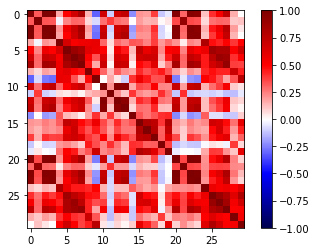

In [203]:
plt.imshow(np.corrcoef(bc.data.T), cmap="seismic", vmin=-1, vmax=1)
plt.colorbar()

In [204]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold

Here in the first example, we will parameterise over PCA dimensionality $k$ and regularizing parameter for SVM $C$.

Firstly, we'll define some user function which takes in $k$, $C$, and a bunch of other parameters, fitting a PCA model, transforming $X$ and then doing cross-validation with SVM model.

In [205]:
def compute_breast_cancer_data(k, C, cv, X, y):
    X_new = PCA(n_components=k).fit_transform(scale(X))
    # default scoring is accuracy score I think.
    return cross_val_score(SVC(C=C), X_new, y, cv=cv)

Now to parameterise...

In [215]:
K = np.arange(1, 15, dtype=int)
C = np.logspace(-4, 1, 30)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)

In [207]:
with MapContext("examples/PCA_SVC1.pkl", n_jobs=-1, verbose=1) as ctx4:
    pca_svc = ctx4.compute_prod(compute_breast_cancer_data, 
                               K, C,
                               cv=cv,
                               X=bc.data, y=bc.target)

loading from file 'examples/PCA_SVC1.pkl'


In [208]:
results = np.vstack(pca_svc).mean(1)
points = np.asarray(list(it.product(K, C)))

Now we plot the results over the grid, and wow we actually have a clear shift in performance, particularly over the selection of $C$. $K$ appears to be largely irrelevant as long as $K>3$.

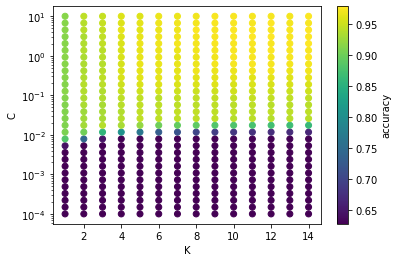

In [209]:
plt.scatter(points[:, 0], points[:, 1], c=results)
plt.colorbar(label="accuracy")
plt.yscale("log")
plt.xlabel("K")
plt.ylabel("C")
plt.show()

### Optimizations

In the above function `compute_breast_cancer_data`:

```python
def compute_breast_cancer_data(k, C, cv, X, y):
    # compute pca reduced data.
    X_new = PCA(n_components=k).fit_transform(scale(X))
    # fit model and score.
    return cross_val_score(SVC(C=C), X_new, y, cv=cv)
```

we notice that it depends on two variables $k$ and $C$ for variation. $k$ is required for PCA and $C$ is required for the parameter for SVMs in model fitting. Those eagle-eyed among you may notice that there are redundant calculations for PCA within the product loop that could be eliminated; specifically $k$ is only length 15, and $C$ is length 30. Thus we could for efficiency split this function into two:

1. A function that takes inputs, calculates PCA fit and returns `x_new`.
2. A function that takes inputs and `x_new`, and returns the model score.

And then design the following pipeline:

    fixed keyword args -> f_pca(k) -> f_model(C) -> result
    
To achieve this, we need some kind of manager of functions, inputs and more. But to begin with, let's rewrite these functions:

In [210]:
from gitermap import umap
from functools import partial

In [217]:
def pca_chain(k, X):
    # pca chain is only dependent on k and X
    return PCA(n_components=k).fit_transform(scale(X))

def model_chain(C, x_new, cv, y):
    # model chain needs x_new as well as remaining args C, cv, and y
    return cross_val_score(SVC(C=C), x_new, y, cv=cv)

Now we re-package the problem such that the PCA chains are run first, then the outputs are fed as values to a product for model chain.

In [225]:
X_new = umap(pca_chain, K, X=bc.data)
with MapContext(n_jobs=-1) as mtx:
    chain1 = mtx.compute_prod(model_chain, C, X_new, cv=cv, y=bc.target)

100%|██████████| 14/14 [00:00<00:00, 131.68it/s]


  0%|          | 0/420 [00:00<?, ?it/s]

Admittedly, the speed up wasn't significant as the majority cost occurs with using RepeatedKFold, but there may be situations where pre-computation is necessary.